여기에 블렌딩 관련 작업

In [3]:
# from desktop w/ gpu
import tensorflow as tf
import numpy as np
import cv2
import time
import os
from enum import Enum
import keras_cv
import keras
import matplotlib.pyplot as plt
# from utils import *
from multipledispatch import dispatch
import mrs3 as mr
import interpolation as inter

print(keras_cv.__version__)
print(keras.__version__)

print(tf.config.list_physical_devices('GPU'))
print(cv2.__version__)
print(cv2.cuda.getCudaEnabledDeviceCount())
print(tf.__version__)

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices() )
print(cv2.getBuildInformation())

%load_ext autoreload
%autoreload 2


lenna_path = 'Lenna_(test_image).png'


0.9.0
2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
4.12.0-dev
1
2.15.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10311214877716712192
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10177478656
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13567830665886237086
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]

General configuration for OpenCV 4.12.0-dev =====================================
  Version control:               4.11.0-356-g325e59bd4c

  Extra modules:
    Location (extra):            /home/primarina314/opencv_contrib/modules
    Version control (extra):     4.11.0-42-gacd145f4

  Platform:
    Timestamp:                   2025-04-28T09:41:11Z
    Host:                        Linux 5.15.167.4-microsoft-standard-WSL2 x86_64
    CMake:                       3.31.2
    CMake g

2025-05-12 01:12:47.280173: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-12 01:12:47.280241: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-12 01:12:47.280263: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-12 01:12:47.280477: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-12 01:12:47.280493: I tensorflow/core/common_runtime/gpu/gpu

In [1]:
# from laptop w/o gpu
import numpy as np
import cv2
import time
import os
from enum import Enum
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
from utils import *

print(cv2.__version__)

%load_ext autoreload
%autoreload 2

4.12.0-dev


In [9]:
mr.compress_img_mult_tgs('sample-images-png/1920x1080.png', 'results', 4, 0)

original file: 864398
downscaled filesize: 219310
roi filesize: 70813
roi bin filesize: 1167
config filesize: 152
compression ratio: 0.3371618166631575


In [10]:
mr.restore_img_mult_tgs('results', mr.EDSR, 'results2')

# 경계 블렌딩

우선 아래 방법 적용하지 않은 상태로 구현

- 원본 파트에서 경계에서 떨어진 거리에 따라 블렌딩 비율 다르게
- 경계에 가까울수록 downscaled->upscaled 이미지 비율을 높게 잡고
- 경계에서 멀어질수록 original part 이미지 비율을 높게 설정하여 블렌딩
- 일정 거리 이상으로 멀어지면 100% 원본파트
- 선형, sigmoid 등 함수로 interpolation
- roi 선택 시에 각 좌표를 모두 저장 -> 좌표를 바탕으로 거리 계산 -> 곡선형태로 저장할 수도 있으므로 더 광범위하게 적용가능한 findContour 함수로 처리하는게 나을듯

In [2]:
class blend_mode(Enum):
    alpha = 0
    poisson = 1
    laplacian = 2
    grad = 3
    dl = 4

def blending_two_images(src, target, mask, mode = blend_mode.poisson, center = (0, 0)):
    match mode:
        case blend_mode.alpha:
            result = cv2.addWeighted(src, 0.7, target, 0.3, 0, mask=mask)
        case blend_mode.poisson:
            result = cv2.seamlessClone(
                src, target, mask, center, cv2.MIXED_CLONE
            )
        case blend_mode.laplacian:
            # laplacian dist
            return
        case blend_mode.grad:
            # gradient
            return
        case blend_mode.dl:
            # dl model
            return

    return result

In [3]:
img_path = 'Lenna_(test_image).png'

# down->upscaled 된거 path
# original part path

output_path = 'blending-test'

# 블렌딩

In [36]:
import mrs3 as mr
roi, _ = mr._select_polygon_roi(img_path)
mask = np.all(roi != [0, 0, 0], axis=2)
mask_uint8 = mask.astype(np.uint8) * 255

cropped target: (419, 388, 3)
cropped mask: (419, 388)


In [94]:
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# print(contours)
print(contours[0].shape)
print(contours[0].reshape(-1, 2))
print(contours[0].reshape(-1, 2).shape)

(1319, 1, 2)
[[ 8  0]
 [ 8  1]
 [ 9  2]
 ...
 [11  1]
 [10  1]
 [ 9  0]]
(1319, 2)


In [40]:
polygon = contours[0].reshape(-1, 2)
test = np.zeros(mask_uint8.shape[:2], dtype=np.uint8)
cv2.fillPoly(test, [np.array(polygon)], 255)

print(mask_uint8.shape)
print(test.shape)

same = 0
diff = 0

for i in range(len(mask_uint8)):
    for j in range(len(mask_uint8[i])):
        if mask_uint8[i][j] == test[i][j]:
            same += 1
        else:
            diff += 1

print(same)
print(diff)


(419, 388)
(419, 388)
162572
0


In [ ]:
cv2.imshow('test', test)
cv2.waitKey(0)

cv2.imshow('mask', mask_uint8)
cv2.waitKey(0)

cv2.destroyAllWindows()


In [9]:
cv2.imwrite('bin-img.png', mask_uint8, [cv2.IMWRITE_PNG_COMPRESSION, 9, cv2.IMWRITE_PNG_BILEVEL, 1])
cv2.imwrite('bin-img.jpeg', mask_uint8)
cv2.imwrite('roi-test.png', roi, [cv2.IMWRITE_PNG_COMPRESSION, 9])

True

In [10]:
print(os.path.getsize('bin-img.png'))
print(os.path.getsize('roi-test.png'))

print(os.path.getsize('Lenna_(test_image).png'))

584
41974
473831


In [15]:
cv2.imshow('test', mask_uint8)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:


def point_line_distance(point, line_start, line_end):
    """
    점과 선분 사이의 최소 수직거리 계산
    point: (x, y) 튜플
    line_start, line_end: 선분의 두 끝점 (x, y) 튜플
    """
    px, py = point
    x1, y1 = line_start
    x2, y2 = line_end

    # 선분 벡터
    line_vec = np.array([x2 - x1, y2 - y1])
    # 점과 선분 시작점 벡터
    point_vec = np.array([px - x1, py - y1])

    line_len_sq = np.dot(line_vec, line_vec)
    if line_len_sq == 0:
        # 선분이 점인 경우
        return np.linalg.norm(point_vec)

    # 점에서 선분으로의 투영 비율
    t = np.dot(point_vec, line_vec) / line_len_sq

    if t < 0.0:
        # 투영점이 선분 시작점 밖에 있는 경우
        closest_point = np.array([x1, y1])
    elif t > 1.0:
        # 투영점이 선분 끝점 밖에 있는 경우
        closest_point = np.array([x2, y2])
    else:
        # 투영점이 선분 위에 있는 경우
        closest_point = np.array([x1, y1]) + t * line_vec

    # 점과 가장 가까운 점 사이 거리
    dist = np.linalg.norm(np.array([px, py]) - closest_point)
    return dist

def is_point_inside_polygon(point, polygon):
    """
    점이 다각형 내부에 있는지 확인 (Ray casting algorithm)
    point: (x, y) 튜플
    polygon: 다각형 꼭짓점 좌표 배열 [(x1,y1), (x2,y2), ...]
    """
    x, y = point
    n = len(polygon)
    inside = False
    
    p1x, p1y = polygon[0]
    for i in range(n + 1):
        p2x, p2y = polygon[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    
    return inside

# class 


def distance_to_polygon_edge_from_mask(mask, point):
    """
    mask: 2D numpy array, 다각형 영역이 1(또는 255), 배경이 0인 바이너리 마스크
    point: (x, y) 튜플, 기준점 좌표

    반환값: point에서 다각형 경계까지의 최소 수직거리 (float)
    """
    # 마스크를 바이너리(0 또는 255)로 변환
    mask_bin = (mask > 0).astype(np.uint8) * 255

    # 다각형 외곽선(경계) 검출
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None  # 다각형이 없는 경우
    
    # 다각형 꼭짓점 좌표 추출
    polygon = contours[0].reshape(-1, 2)

    # 점이 다각형 내부에 있는지 확인
    inside = is_point_inside_polygon(point, polygon)

    min_dist = float('inf')
    for contour in contours:
        pts = contour.reshape(-1, 2)
        n = len(pts)
        for i in range(n):
            start = tuple(pts[i])
            end = tuple(pts[(i + 1) % n])
            dist = point_line_distance(point, start, end)
            if dist < min_dist:
                min_dist = dist

    return min_dist if inside else -min_dist

def distance_to_polygon_edge_from_contours(contours, point):
    """
    point: (x, y) 튜플, 기준점 좌표
    contours: contours 튜플(vertices). cv2.findContours 의 0번째 컴포넌트
    반환값: point에서 다각형 경계까지의 최소 수직거리 (float) - 부호 고려
    """

    if len(contours) == 0:
        return None  # 다각형이 없는 경우
    
    # 다각형 꼭짓점 좌표 추출
    polygon = contours[0].reshape(-1, 2)

    # 점이 다각형 내부에 있는지 확인
    inside = is_point_inside_polygon(point, polygon)

    min_dist = float('inf')
    for contour in contours:
        pts = contour.reshape(-1, 2)
        n = len(pts)
        for i in range(n):
            start = tuple(pts[i])
            end = tuple(pts[(i + 1) % n])
            dist = point_line_distance(point, start, end)
            if dist < min_dist:
                min_dist = dist
    return min_dist if inside else -min_dist

# 사용 예시
# mask = np.zeros((200, 200), dtype=np.uint8)
# polygon = np.array([[50, 50], [150, 50], [150, 150], [50, 150]])
# cv2.fillPoly(mask, [polygon], 255)

# point = (100, 100)  # 예시 기준점
# distance = distance_to_polygon_edge(mask, point)
# print(f"Distance from point {point} to polygon edge: {distance}")


In [8]:
# dist = distance_to_polygon_edge(mask, (100, 100))
# print(dist)
mask_bin = (mask > 0).astype(np.uint8) * 255

contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

def check_dist(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        # dist = distance_to_polygon_edge_from_mask(mask, (x, y))
        dist = distance_to_polygon_edge_from_contours(contours, (x, y))
        print(f"distance from ({x}, {y}) to edge: {dist}")

cv2.namedWindow("test")
cv2.setMouseCallback("test", check_dist)

cv2.imshow('test', mask_uint8)

clicking = True
while True:
    key = cv2.waitKey(1)
    if key == 27:
        break

cv2.destroyAllWindows()

distance from (73, 92) to edge: 43.04648650006177
distance from (40, 22) to edge: -33.54101966249684
distance from (64, 49) to edge: 1.0
distance from (42, 51) to edge: -7.211102550927978
distance from (42, 55) to edge: -3.605551275463989
distance from (42, 57) to edge: -2.0
distance from (39, 65) to edge: 3.605551275463989
distance from (34, 64) to edge: 0.7071067811865476
distance from (69, 107) to edge: 54.56189146281496
distance from (3, 29) to edge: -44.721359549995796
distance from (85, 124) to edge: 38.01315561749642
distance from (29, 31) to edge: -30.870698080866262
distance from (79, 110) to edge: 47.853944456021594
distance from (72, 90) to edge: 40.8166632639171
distance from (90, 77) to edge: 34.713109915419565


In [ ]:
mrs3_compress(img_path, output_path, 4, ROI_mode.Polygon)


original file: 473831
downscaled filesize: 35816
roi filesize: 27504
config filesize: 97
compression ratio: 0.1338388581582885


In [6]:
mrs3_restore('qwergfhfghgfhgfg', MRS3_mode.edsr, 'qwergfhfghgfhgfg/restored.png')

In [7]:
def distance_to_polygon_edge(mask, point):
    """
    mask: 2D numpy array, polygon 영역이 1(또는 255), 배경이 0인 바이너리 마스크
    point: (x, y) 튜플, 기준점 좌표

    반환값: point에서 다각형 경계까지의 최단 거리 (float)
    """
    # 마스크를 바이너리(0 또는 255)로 변환
    mask_bin = (mask > 0).astype(np.uint8) * 255

    # 다각형 외곽선(경계) 검출
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None  # 다각형이 없는 경우

    # 모든 경계점에 대해 거리 계산, 최솟값 반환
    min_dist = float('inf')
    for contour in contours:
        for pt in contour:
            dist = np.linalg.norm(np.array(pt[0]) - np.array(point))
            if dist < min_dist:
                min_dist = dist

    return min_dist

# 사용 예시
# mask: 다각형이 그려진 바이너리 마스크 (예: 200x200, 가운데 사각형)
# mask = np.zeros((200, 200), dtype=np.uint8)
# polygon = np.array([[50, 50], [150, 50], [150, 150], [50, 150]])
# cv2.fillPoly(mask, [polygon], 255)

# point = (100, 100)  # 예시 기준점

# distance = distance_to_polygon_edge(mask, point)
# print(f"Distance from point {point} to polygon edge: {distance}")


In [1]:
import interpolation as inter

print(inter.hermit_3(6))

1


In [ ]:
class blending_interpolation_mode(Enum):
    LINEAR = 0
    HERMIT_3 = 1
    HERMIT_5 = 2
    SINUSOIDAL = 3
    EXPONENTIAL = 4
    SINH = 5

# replace s = (x - a) / (b - a)
# f(x) = (x - a) / (b - a)
# f(x) = 3x² - 2x³
# f(x) = 6x⁵ - 15x⁴ + 10x³
# f(x) = (1 - cos(πx)) / 2



def get_alpha():

    return

def blending_with_interpolation():

    return

In [72]:
class Person:
    def __init__(self, first_name, last_name, age):
        self.first_name = first_name
        self.last_name = last_name
        self.__age = age  # 내부 변수로 저장
        
    @property
    def age(self):
        return self.__age
    
    @age.setter
    def age(self, newage):
        self.__age = newage


p = Person("qwer", "asdf", 20)

In [73]:
print(p.age)

20


In [78]:
print(type('asdf'))

<class 'str'>


In [6]:
import utils as ut

In [41]:
import mrs3 as mr



In [66]:
l = mr._select_multiple_polygon_roi('Lenna_(test_image).png')

In [67]:
print(len(l))

3


In [68]:
for item in l:
    cv2.imshow('asdf', item[0])
    cv2.imshow('qwer', item[1])
    print(item[2])
    cv2.waitKey(0)
    cv2.destroyAllWindows()

(123, 461, 137, 367)
(40, 153, 64, 273)
(300, 473, 25, 141)


In [3]:
mr.compress_img_mult_tgs('sample-images-png/1920x1080.png', 'results', 4, 0)

original file: 864398
downscaled filesize: 219310
roi filesize: 143681
roi bin filesize: 1614
config filesize: 152
compression ratio: 0.42197807028706685


In [4]:
mr.restore_img_mult_tgs('results', mr.EDSR, 'results2')

In [85]:
mask_test = cv2.imread('results/bin0.png')
print(mask_test.shape)
cv2.imshow('qwer', mask_test)
cv2.waitKey(0)
cv2.destroyAllWindows()

(297, 277, 3)


In [80]:
print(mask_test.shape)
print(mask_test.dtype)
cv2.imshow('test', mask_test)
cv2.waitKey(0)
cv2.destroyAllWindows()

(297, 277, 3)
uint8


In [ ]:
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# print(contours)
print(contours[0].shape)
print(contours[0].reshape(-1, 2))
print(contours[0].reshape(-1, 2).shape)

In [57]:
mr.restore_img_mult_tgs('results', mr.EDSR, 'results2')

In [89]:
test = cv2.imread('results/bin0.png')
gray_img = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
_, binary_img_255 = cv2.threshold(gray_img, 127, 255, cv2.THRESH_BINARY)

print(test.shape)
print(gray_img.shape)
print(binary_img_255.shape)



(297, 277, 3)
(297, 277)
(297, 277)


In [90]:
for i in range(10,20):
    print(i)

10
11
12
13
14
15
16
17
18
19


# 블렌딩 예제

1. 알파 블렌딩 (Alpha Blending)
알파 블렌딩은 두 이미지에 가중치를 주어 합성하는 가장 기본적인 방법입니다. 단순 덧셈과 달리 오버플로우 문제를 방지하고 자연스러운 합성이 가능합니다.

In [ ]:
import cv2
import numpy as np

# 이미지 로드
img1 = cv2.imread('image1.jpg')
img2 = cv2.imread('image2.jpg')

# 두 이미지의 크기가 같아야 함
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

# 방법 1: 직접 구현
alpha = 0.5
blended1 = (img1 * alpha) + (img2 * (1-alpha))
blended1 = blended1.astype(np.uint8)  # 소수점 제거

# 방법 2: OpenCV 함수 사용
blended2 = cv2.addWeighted(img1, alpha, img2, (1-alpha), 0)

# 결과 출력
cv2.imshow('Blended Image', blended2)
cv2.waitKey(0)


2. 이미지 피라미드를 이용한 블렌딩
가우시안 피라미드와 라플라시안 피라미드를 사용하여 두 이미지의 경계를 더 자연스럽게 합성할 수 있습니다.

In [ ]:
import cv2
import numpy as np

# 이미지 로드 및 리사이징
A = cv2.imread('image1.jpg')
B = cv2.imread('image2.jpg')
A = cv2.resize(A, (512, 512))
B = cv2.resize(B, (512, 512))

# 두 이미지를 합칠 마스크 생성 (왼쪽: A, 오른쪽: B)
rows, cols, _ = A.shape
mask = np.zeros((rows, cols, 3), dtype='uint8')
mask[:, 0:cols//2] = 255

# 가우시안 피라미드 생성
G = A.copy()
gpA = [G]
for i in range(6):
    G = cv2.pyrDown(G)
    gpA.append(G)

G = B.copy()
gpB = [G]
for i in range(6):
    G = cv2.pyrDown(G)
    gpB.append(G)

# 라플라시안 피라미드 생성
lpA = [gpA[5]]
for i in range(5, 0, -1):
    GE = cv2.pyrUp(gpA[i])
    L = cv2.subtract(gpA[i-1], GE)
    lpA.append(L)

lpB = [gpB[5]]
for i in range(5, 0, -1):
    GE = cv2.pyrUp(gpB[i])
    L = cv2.subtract(gpB[i-1], GE)
    lpB.append(L)

# 라플라시안 피라미드 합성
LS = []
for la, lb in zip(lpA, lpB):
    rows, cols, _ = la.shape
    ls = np.hstack((la[:, 0:cols//2], lb[:, cols//2:]))
    LS.append(ls)

# 이미지 재구성
ls_ = LS[0]
for i in range(1, 6):
    ls_ = cv2.pyrUp(ls_)
    ls_ = cv2.add(ls_, LS[i])

# 결과 출력
cv2.imshow("Pyramid Blended", ls_)
cv2.waitKey(0)


3. 시멀리스 클로닝 (Seamless Cloning)
OpenCV의 seamlessClone 함수를 사용하면 두 이미지의 경계를 매우 자연스럽게 합성할 수 있습니다. 이 방법은 2023년 5월 3일 업데이트된 OpenCV 문서에서도 다루고 있습니다.

In [ ]:
import cv2
import numpy as np

# 이미지 로드
src = cv2.imread('source.jpg')  # 합성할 객체가 있는 이미지
dst = cv2.imread('destination.jpg')  # 배경 이미지

# 소스 이미지 크기 조정 (필요시)
src = cv2.resize(src, (300, 300))

# 마스크 생성 (소스 이미지에서 합성할 영역)
mask = np.zeros(src.shape, src.dtype)
poly = np.array([[50, 50], [250, 50], [250, 250], [50, 250]], np.int32)
cv2.fillPoly(mask, [poly], (255, 255, 255))

# 합성 위치 (배경 이미지 내 중심점)
center = (dst.shape[1]//2, dst.shape[0]//2)

# 시멀리스 클로닝 적용
# 1. 일반 클로닝
normal_clone = cv2.seamlessClone(src, dst, mask, center, cv2.NORMAL_CLONE)

# 2. 혼합 클로닝
mixed_clone = cv2.seamlessClone(src, dst, mask, center, cv2.MIXED_CLONE)

# 결과 출력
cv2.imshow("Normal Clone", normal_clone)
cv2.imshow("Mixed Clone", mixed_clone)
cv2.waitKey(0)


4. 투명 PNG 오버레이
알파 채널이 있는 PNG 이미지를 다른 이미지 위에 자연스럽게 오버레이하는 방법입니다.

In [ ]:
import cv2
import numpy as np

# 배경 이미지 로드
background = cv2.imread('background.jpg')

# 알파 채널이 있는 전경 이미지 로드
foreground = cv2.imread('foreground.png', cv2.IMREAD_UNCHANGED)

# 크기 조정 (필요시)
foreground = cv2.resize(foreground, (300, 300))

# 알파 채널 분리
alpha_channel = foreground[:, :, 3] / 255.0
alpha_channel = np.repeat(alpha_channel[:, :, np.newaxis], 3, axis=2)

# 전경과 배경 합성
foreground_rgb = foreground[:, :, :3]
background_roi = background[0:foreground.shape[0], 0:foreground.shape[1]]

# 알파 블렌딩 공식 적용
blended = foreground_rgb * alpha_channel + background_roi * (1 - alpha_channel)
blended = blended.astype(np.uint8)

# 결과 이미지에 합성 결과 삽입
result = background.copy()
result[0:foreground.shape[0], 0:foreground.shape[1]] = blended

# 결과 출력
cv2.imshow("Alpha Blended Overlay", result)
cv2.waitKey(0)


In [14]:
A = np.array([3,4,5,6])
B = np.array([4,5,7,9])
A * 0.2 + B * 0.8

array([3.8, 4.8, 6.6, 8.4])

In [12]:
img = cv2.imread(lenna_path)

img[0][0].shape

(3,)

In [20]:
bool_ar = np.array([True, False, False, True])
print(bool_ar)

bin_ar = bool_ar.astype(np.uint8) * 255
print(bin_ar)

[ True False False  True]
[255   0   0 255]


In [6]:
roi_mask = cv2.imread('results/bin0.png')

bool_roi_mask = np.all(roi_mask != [0, 0, 0], axis=2)
bin_roi_mask = bool_roi_mask.astype(np.uint8) * 255

In [26]:
print(bool_roi_mask.shape)
print(bin_roi_mask.shape)

(297, 277)
(297, 277)


In [27]:
cv2.imshow('bin', bin_roi_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [7]:
mask = cv2.imread('results/bin0.png')
mask = np.all(mask != [0, 0 ,0], axis=2).astype(np.uint8) * 255
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(contours[0].shape)

(282, 1, 2)


<class 'numpy.ndarray'>
(500, 500)


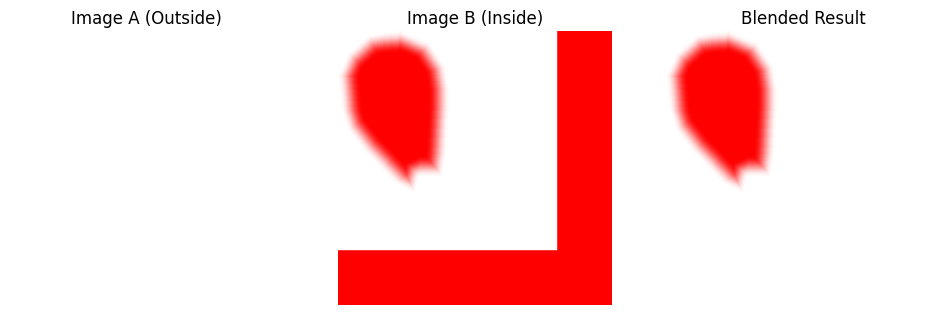

In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def blend_images_with_contour_distance(A, B, contour):
    """
    A, B: 두 이미지 (같은 크기, 3채널, uint8)
    contour: 다각형 외곽선 (Nx1x2 형태의 numpy 배열)
    max_distance: 거리 임계값 (이 거리 이상이면 A 가중치 0, B 가중치 1)
    
    contour 외부는 A로 채우고, contour 내부는 contour로부터의 거리 기반 알파 블렌딩
    """
    # 이미지 크기
    h, w = A.shape[:2]
    
    # 빈 마스크 생성 (contour 내부 255, 외부 0)
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=-1)
    
    # contour 내부 픽셀에 대해 거리 변환 (contour 경계까지 거리)
    dist_transform = cv2.distanceTransform(mask, distanceType=cv2.DIST_L2, maskSize=3)
    max_distance = np.max(dist_transform) * .4
    # 거리 임계값 이상인 부분은 B만 사용
    # 거리 임계값 이하인 부분은 거리 비례 가중치 계산
    
    # 거리 최대값으로 정규화 (0~1)
    # alpha = np.clip(1 - dist_transform / max_distance, 0, 1)
    # alpha = inter.np_linear(1 - dist_transform / max_distance, 0, 1)
    # alpha = inter.np_hermit_3(1 - dist_transform / max_distance, 0, 1)
    # alpha = inter.np_hermit_5(1 - dist_transform / max_distance, 0, 1)
    alpha = inter.np_sinusoidal(1 - dist_transform / max_distance, 0, 1)

    print(type(alpha))
    print(alpha.shape)
    
    # contour 외부는 alpha=1 (A만 사용)
    alpha[mask == 0] = 1
    
    # alpha는 A의 가중치, (1-alpha)는 B의 가중치
    alpha_3ch = np.repeat(alpha[:, :, np.newaxis], 3, axis=2)
    
    # float32로 변환하여 가중치 곱셈
    A_f = A.astype(np.float32)
    B_f = B.astype(np.float32)
    
    blended = A_f * alpha_3ch + B_f * (1 - alpha_3ch)
    blended = np.clip(blended, 0, 255).astype(np.uint8)
    
    return blended

# 테스트용 임의 이미지 생성
h, w = 500, 500
A = np.full((h, w, 3), fill_value=255, dtype=np.uint8)  # 흰색 배경
B = np.full((h, w, 3), fill_value=[0, 0, 255], dtype=np.uint8)  # 파란색 배경

# 다각형 contour 생성 (사각형)
# contour = np.array([[[50, 50]], [[250, 50]], [[250, 250]], [[50, 250]]], dtype=np.int32)
contour = contours[0]
# 최대 거리 임계값
max_dist = 20

# 함수 실행
result = blend_images_with_contour_distance(A, B, contour)
B[0:400, 0:400] = mr.blend_images_with_contour_distance(A[0:400, 0:400], B[0:400, 0:400], contour)

# result = mr.blend_images_with_contour_distance(A, B, contour, blend=mr.BLEND_SINUSOIDAL)

# 결과 시각화
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('Image A (Outside)')
plt.imshow(cv2.cvtColor(A, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Image B (Inside)')
plt.imshow(cv2.cvtColor(B, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Blended Result')
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


In [54]:
B[0][0] == result[0][0]

array([ True,  True,  True])

In [23]:
same = 0
diff = 0
for i in range(400):
    for j in range(400):
        if np.all(B[i][j] == result[i][j]):
            same += 1
        else:
            diff += 1
print(same)
print(diff)


160000
0


In [ ]:
A = np.array([-0.3])
B = inter.np_unit_step(A)
print(B)

[0]


In [2]:
def foo():
    pass


foo()


def foo():
    print('asdfds')



In [7]:
step = inter.step(1.6,2)

step(3)

1.6

In [9]:
np.clip(4, 5, 5.6)

5.0

In [11]:
ar = np.array([3,5,6,7,8,45,3567,-435])

print(max(ar))
print(min(ar))

3567
-435
